![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)



---


# **Miniproyecto 4: Desafío del Procesamiento de Lenguaje Natural (NLP).**
# ***THE FAKE NEWS.***

---





---


### **Prof. Carlos Danino**
### **David Arenas**
### **Juan A. Peñalver**


---



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 31 17:41:37 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import psutil

ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# =======================================================
#                     MINI PROYECTO 4:
# =======================================================
#  Natural Language Processing Challenge: The Fake News.
# =======================================================

# ============================
#  IMPORTACIONES DE LIBRERÍAS
# ============================

import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel
from transformers import pipeline

# -------------------
#  Reproducibilidad.
# -------------------

seed = 29
np.random.seed(seed)


In [ ]:
# ========================================================================
#  MONTADO DE LAS CARPETAS DE GOGLE COLAB SOBRE LA UNIDAD DE GOOCLE DRIVE
# ========================================================================

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ---------------------------------
#  Cargar los CSV (misma carpeta).
# ---------------------------------

PATH        = "/content/drive/MyDrive/Miniproyecto 3/dataset"
TRAIN_PATH  = "/content/drive/MyDrive/Miniproyecto 3/dataset/training_data.csv"
TEST_PATH   = "/content/drive/MyDrive/Miniproyecto 3/dataset/testing_data.csv"
OUTPUT_PATH = "/content/drive/MyDrive/Miniproyecto 3/dataset/testing_data_predicted.csv"

train_df = pd.read_csv(TRAIN_PATH, sep="\t", header=None, names = ["label", "headline"])
test_df  = pd.read_csv(TEST_PATH,  sep="\t", header=None, names = ["label", "headline"])

# ------------------------------
#  Verificar que cargaron bien.
# ------------------------------

print()
print(f"Training data head:\n{train_df.head()}")
print()
print(f"Testing data head:\n{test_df.head()}")
print()
print()
print(f"Training data info:\n{train_df.info()}")
print()
print(f"Testing data info:\n{test_df.info()}")
print()



Training data head:
   label                                           headline
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...

Testing data head:
  label                                           headline
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     34152 non-null  int64 
 1   headline  34152 

In [ ]:
# --------------------
#  Separar variables.
# --------------------

x = train_df["headline"].astype(str)
y = train_df["label"].astype(int).values
x_test = test_df["headline"].astype(str)


In [ ]:
# =====================
#  PREPARACIÓN DE BERT
# =====================

tokenizer  = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

bert_model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# ============================
#  EXTRACCIÓN DE "EMBEDDINGS"
# ============================

def get_bert_embeddings(sentences, batch_size=16):

    all_embeddings = []

    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch = sentences.iloc[i:i+batch_size].tolist()

            inputs = tokenizer(
                batch,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            outputs = bert_model(**inputs)

            # --------------------------------
            #  "Embedding" del "token" [CLS].
            # --------------------------------
            cls_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
            all_embeddings.append(cls_embeddings)

    return np.vstack(all_embeddings)

print("Extrayendo embeddings de BERT...")
X_embeddings = get_bert_embeddings(x)


Extrayendo embeddings de BERT...


In [ ]:
# ==========================
#  PREPARACIÓN DE LOS DATOS
# ==========================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --------------------------------------------
#  PASO 1: Separar features (X) y target (y).
# --------------------------------------------

X = X_embeddings
y = y

# -----------------------------------------
#  PASO 2: Split train/validation (80/20).
# -----------------------------------------
# stratify = y (mantiene la proporción de clases).

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,        # 20% para validación.
    random_state=seed,    # Reproducibilidad.
    stratify=y            # Mantener la proporción "fake/real".
)

print(f"Train: {len(X_train)} titulares")
print(f"Validation: {len(X_val)} titulares")
print(f"Total: {len(X)} titulares")
print()

# --------------------------
#  PASO 3: Estandarización.
# --------------------------
# ANN requiere que los datos estén estandarizados (en este enfoque).
# ¡¡IMPORTANTE!!: el "scaler" se ajusta SOLAMENTE con "train" para evitar el "data leakage".

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # "Fit" SOLOMENTE en "train"
X_val_scaled   = scaler.transform(X_val)        # "Transform" en "validation" (mismo "scaler")


Train: 27321 titulares
Validation: 6831 titulares
Total: 34152 titulares



In [ ]:
# =======================================
#  ARQUITECTURA DE LA RED NEURONAL (ANN)
# =======================================

from tensorflow.keras.layers import Input  # Importar la capa Input

model = Sequential()

model.add(Input(shape=(768,)))             # Capa de entrada: 768 dimensiones (BERT)

model.add(Dense(32, activation='relu'))    # 32 neuronas, con relu
model.add(Dropout(0.33))                   # Dropout 33%
model.add(Dense(32, activation='relu'))    # 32 neuronas, con relu
model.add(Dropout(0.33))                   # Dropout 33%

model.add(Dense(1, activation='sigmoid'))  # Capa de salida: 1 neurona, sigmoid

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,697 (100.38 KB)

 Trainable params: 25,697 (100.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================
#  COMPILAR Y ENTRENAR MODELO
# ============================

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer=SGD(learning_rate=0.01),      # SGD con LR=0,01
    loss='binary_crossentropy',             # Loss para clasificación binaria
    metrics=['accuracy'])                   # Métrica: accuracy

early_stop = EarlyStopping(
    monitor='val_loss',                     # Monitorear loss de validación
    patience=5,                             # Esperar 5 épocas sin mejora
    restore_best_weights=True,              # Restaurar mejores pesos
    verbose=1)                              # Mostrar cuando se detiene

history = model.fit(
    X_train_scaled, y_train,                # Datos de entrenamiento
    epochs=200,                             # Máximo 200 épocas
    batch_size=6,                           # Batch muy pequeño (pocos datos)
    validation_data=(X_val_scaled, y_val),  # Validar en validation (fixed: use X_val_scaled, y_val)
    callbacks=[early_stop],                 # Aplicar Early Stopping
    shuffle=True,                           # Mezclar datos en cada época
    verbose=1)                              # Mostrar progreso

print("Modelo entrenado!")


Epoch 1/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.8837 - loss: 0.2782 - val_accuracy: 0.9431 - val_loss: 0.1424
Epoch 2/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9404 - loss: 0.1534 - val_accuracy: 0.9466 - val_loss: 0.1292
Epoch 3/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9508 - loss: 0.1330 - val_accuracy: 0.9504 - val_loss: 0.1236
Epoch 4/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9522 - loss: 0.1254 - val_accuracy: 0.9510 - val_loss: 0.1196
Epoch 5/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9563 - loss: 0.1144 - val_accuracy: 0.9520 - val_loss: 0.1153
Epoch 6/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9602 - loss: 0.1042 - val_accuracy: 0.9542 - val_loss: 0.1133
Epoch 7/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9610 - loss: 0.1023 - val_accuracy: 0.9534 - val_loss: 0.1153
Epoch 8/200
4554/4554 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9653 -

In [ ]:
# ===================
#  EVALUAR EL MODELO
# ===================

from sklearn.metrics import (
    fbeta_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score
)

# --------------------------------------------
#  Predicciones en VALIDATION (X_val_scaled).
# --------------------------------------------
y_val_pred = (model.predict(X_val_scaled, verbose=0) > 0.5).astype(int).flatten()

# ----------------------------------------------
#  Predicciones en TRAIN - chequeo overfitting.
# ----------------------------------------------
y_train_pred = (model.predict(X_train_scaled, verbose=0) > 0.5).astype(int).flatten()

# ----------------------------------------------------------------------------------------
#  β=3 priorizo Recall de FAKE (label=0) para no dejar pasar noticias falsas como reales.
# ----------------------------------------------------------------------------------------
# Nota: fbeta_score por defecto considera la clase positiva como 1.
# Como aquí queremos priorizar la clase 0 (FAKE), usamos pos_label=0.

beta = 3

fbeta_val = fbeta_score(y_val, y_val_pred, beta=beta, pos_label=0)
print(f"F-Beta Score VALIDATION (β={beta}, FAKE=0):  {fbeta_val:.4f}")

fbeta_train = fbeta_score(y_train, y_train_pred, beta=beta, pos_label=0)
print(f"F-Beta Score TRAIN (β={beta}, FAKE=0):       {fbeta_train:.4f}")

# ----------------------------------------
#  Accuracy (métrica adicional estándar).
# ----------------------------------------

acc_val = accuracy_score(y_val, y_val_pred)
acc_train = accuracy_score(y_train, y_train_pred)
print(f"\nAccuracy VALIDATION: {acc_val:.4f}")
print(f"Accuracy TRAIN:      {acc_train:.4f}\n")


F-Beta Score VALIDATION (β=3, FAKE=0):  0.9559
F-Beta Score TRAIN (β=3, FAKE=0):       0.9754

Accuracy VALIDATION: 0.9593
Accuracy TRAIN:      0.9795



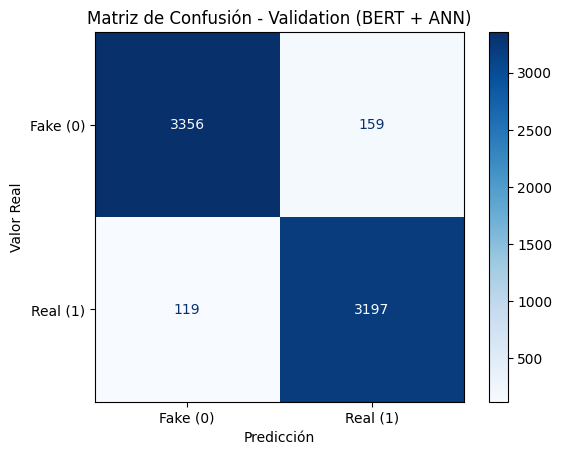


Detalle Matriz de Confusión (Validation):
  Verdaderos Negativos (TN): 3356 - Fake detectada correctamente (0→0)
  Falsos Positivos (FP):     159 - Fake clasificada como Real (0→1) - CRÍTICO
  Falsos Negativos (FN):     119 - Real clasificada como Fake (1→0)
  Verdaderos Positivos (TP): 3197 - Real detectada correctamente (1→1)

Classification Report (Validation):
              precision    recall  f1-score   support

    Fake (0)       0.97      0.95      0.96      3515
    Real (1)       0.95      0.96      0.96      3316

    accuracy                           0.96      6831
   macro avg       0.96      0.96      0.96      6831
weighted avg       0.96      0.96      0.96      6831



In [ ]:
# =====================
#  MATRIZ DE CONFUSIÓN
# =====================

# --------------------------------------------
#  Crear y visualizar la matriz de confusión.
# --------------------------------------------

cm_val = confusion_matrix(y_val, y_val_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Fake (0)", "Real (1)"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de Confusión - Validation (BERT + ANN)")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

# ------------------------------------------------
#  Interpretación de la matriz (para el reporte).
# ------------------------------------------------

TN = cm_val[0, 0]  # Fake predicho como Fake.
FP = cm_val[0, 1]  # Fake predicho como Real (peligroso: fake pasa como real).
FN = cm_val[1, 0]  # Real predicho como Fake.
TP = cm_val[1, 1]  # Real predicho como Real.

print()
print("Detalle Matriz de Confusión (Validation):")
print(f"  Verdaderos Negativos (TN): {TN} - Fake detectada correctamente (0→0)")
print(f"  Falsos Positivos (FP):     {FP} - Fake clasificada como Real (0→1) - CRÍTICO")
print(f"  Falsos Negativos (FN):     {FN} - Real clasificada como Fake (1→0)")
print(f"  Verdaderos Positivos (TP): {TP} - Real detectada correctamente (1→1)\n")

# -----------------------------------------
#  Reporte adicional (opcional pero útil).
# -----------------------------------------

print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred, target_names=["Fake (0)", "Real (1)"]))


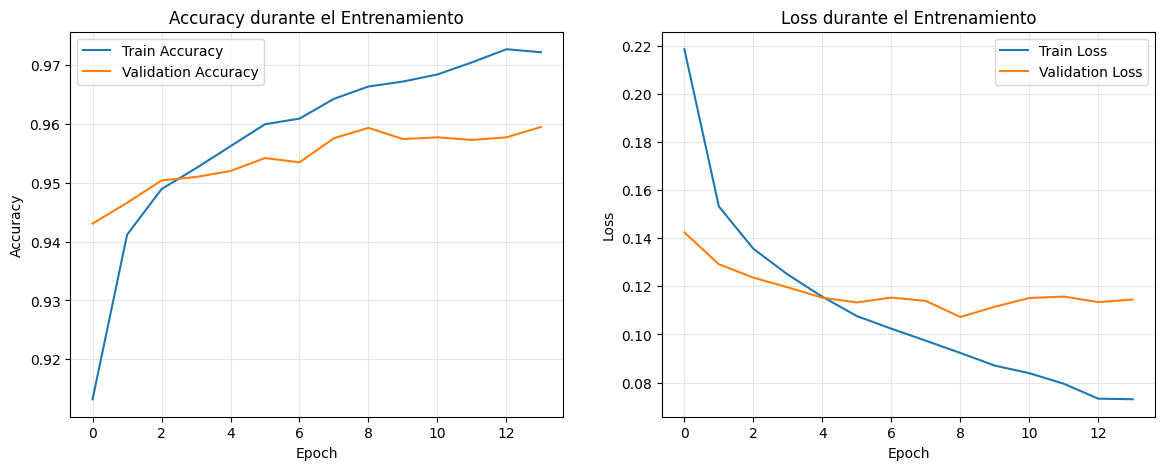


Mejor época:  8


TRAIN:
Loss óptimo: 0.0923
Accuracy óptimo: 96.63%
Loss final: 0.0731
Accuracy final: 97.21%

VALIDATION:
Loss óptimo: 0.1073
Accuracy óptimo: 95.93%
Loss final: 0.1145
Accuracy final: 95.94%



In [ ]:
# ============================================
#  VISUALIZACIÓN DE LAS CURVAS DE APRENDIZAJE
# ============================================

# ---------------------------------
#  Crear figura con 2 subgráficos.
# ---------------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# ----------------------------------
#  Gráfico 1: Accuracy (Exactitud).
# ----------------------------------

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy durante el Entrenamiento')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ----------------------------
#  Gráfico 2: Loss (Pérdida).
# ----------------------------

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss durante el Entrenamiento')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.show()

# -------------
#  Mejor época
# -------------

print()
best_epoch = np.argmin(history.history['val_loss'])
print(f"Mejor época: ", best_epoch)
print()

print()
print(f"TRAIN:")
print(f"Loss óptimo: {history.history['loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['accuracy'][-1]*100:.2f}%")
print()
print(f"VALIDATION:")
print(f"Loss óptimo: {history.history['val_loss'][best_epoch]:.4f}")
print(f"Accuracy óptimo: {history.history['val_accuracy'][best_epoch]*100:.2f}%")
print(f"Loss final: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final: {history.history['val_accuracy'][-1]*100:.2f}%")
print()


In [ ]:
# ================================================
#  PROBAR EL MODELO CON x_test (testing_data.csv)
# ================================================

# x_test debe ser: test_df["headline"].astype(str)
# Nota: aquí NO hay y_test real, así que solo podemos predecir, no evaluar.

# --------------------------------------------------
#  Paso 1: Generar embeddings con BERT para x_test.
# --------------------------------------------------

print("Extrayendo embeddings de BERT para x_test...")
print("--------------------------------------------")
X_test = get_bert_embeddings(x_test)

# --------------------------------------------------------
#  Paso 2: Estandarizar con el scaler aprendido en train.
# --------------------------------------------------------

print("Estandarizando embeddings de x_test...")
print("--------------------------------------")
X_test_scaled = scaler.transform(X_test)

# -------------------------------------------
#  Paso 3: Predecir probabilidades y clases.
# -------------------------------------------

print("Generando predicciones para x_test...")
print("-------------------------------------")
y_test_prob = model.predict(X_test_scaled, verbose=0).flatten()  # Probabilidad de clase 1 (REAL)
y_test_pred = (y_test_prob > 0.5).astype(int)                    # 0=FAKE, 1=REAL

# ------------------------------------------------------------
#  Paso 4: Mostrar una muestra de predicciones (10 primeras).
# ------------------------------------------------------------

print("\nMUESTRA DE PREDICCIONES (primeras 10):")
print("----------------------------------------")
for i in range(10):
    titular = x_test.iloc[i] if hasattr(x_test, "iloc") else x_test[i]
    print(f"\nTitular: {titular}")
    print(f"Prob REAL (1): {y_test_prob[i]:.3f} | Predicción: {'REAL (1)' if y_test_pred[i]==1 else 'FAKE (0)'}")

# ----------------------------------------------------------
#  Paso 5: Distribución de clases predichas (sanity check).
# ----------------------------------------------------------

print("\nDistribución de predicciones en x_test:")
print("-----------------------------------------")
unique, counts = np.unique(y_test_pred, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Clase {u} ({'FAKE' if u==0 else 'REAL'}): {c}")

# ----------------------------------------------------------------------------------
#  Paso 6: Generar el archivo final con el mismo formato (tab, sin columnas extra).
# ----------------------------------------------------------------------------------

output_df = test_df.copy()
output_df["label"] = y_test_pred

output_df.to_csv(
    "testing_data_predicted.csv",
    sep="\t",
    header=False,
    index=False
)

print("\nArchivo 'testing_data_predicted.csv' generado correctamente.")


Extrayendo embeddings de BERT para x_test...
--------------------------------------------
Estandarizando embeddings de x_test...
--------------------------------------
Generando predicciones para x_test...
-------------------------------------

MUESTRA DE PREDICCIONES (primeras 10):
----------------------------------------

Titular: copycat muslim terrorist arrested with assault weapons
Prob REAL (1): 0.042 | Predicción: FAKE (0)

Titular: wow! chicago protester caught on camera admits violent activity was pre-planned: ‚it‚s not gonna be peaceful‚
Prob REAL (1): 0.000 | Predicción: FAKE (0)

Titular: germany's fdp look to fill schaeuble's big shoes
Prob REAL (1): 0.996 | Predicción: REAL (1)

Titular: mi school sends welcome back packet warning kids against wearing u.s. flag to school
Prob REAL (1): 0.002 | Predicción: FAKE (0)

Titular: u.n. seeks 'massive' aid boost amid rohingya 'emergency within an emergency'
Prob REAL (1): 1.000 | Predicción: REAL (1)

Titular: did oprah just leav

In [ ]:
# --------------------------------------------------
#  Salida al fichero 'predictions_testing_data.csv'
# --------------------------------------------------

output_df.head(50)


label                                           headline
0       0  copycat muslim terrorist arrested with assault...
1       0  wow! chicago protester caught on camera admits...
2       1   germany's fdp look to fill schaeuble's big shoes
3       0  mi school sends welcome back packet warning ki...
4       1  u.n. seeks 'massive' aid boost amid rohingya '...
5       0  did oprah just leave ‚nasty‚ hillary wishing s...
6       1  france's macron says his job not 'cool' cites ...
7       0  flashback: chilling ‚60 minutes‚ interview wit...
8       1  spanish foreign ministry says to expel north k...
9       1  trump says cuba 'did some bad things' aimed at...
10      1  merkel names refugee expert as foreign policy ...
11      1  brazil house speaker says temer charges must b...
12      0  finger in every pie: how cia produces our ‚new...
13      0  how malia obama‚s pot smoking friend is connec...
14      1  no-one can wreck our democracy schaueble tells...
15      0  media ignores post on facebook from man who th...
16      0  left-wing author blasts democrats for ‚scandal...
17      0  revealed: how democratic party pays agit-prop ...
18      1  macron calls for french food chain changes to ...
19      0  breaking news: gop controlled house votes to r...
20      1  dutch government rolls out carpet for business...
21      1  exclusive: u.s.-backed raqqa battle should end...
22      0  mainstream media fake news: 21st century wire ...
23      1   turkish forces set up positions in syria's idlib
24      0  breaking: [video] controversial mayor who refu...
25      0  arizona bikers are about to become violent ‚dr...
26      1  mexico school collapse spurs doubts over build...
27      0  boiler room #94 ‚ president trump & the great ...
28      0  say what? tide detergent joins forces with ope...
29      0  episode #9 ‚ on the qt: ‚cozy bears & eggnog‚ ...
30      1  germany softens stance on turkish arms sales c...
31      0  man walks into target with undercover camera‚w...
32      0  as hillary crashes and burns‚ the dems look to...
33      0  oops! hillary‚s hit woman lied about trump gro...
34      0        college that receives $280 million in state
35      1  u.s. military in iraq urges iraqis kurds to av...
36      1  singapore man and woman arrested for 'terroris...
37      0  hillary clinton jumps the shark with ‚trump‚s ...
38      1  venezuela's unrest food scarcity take psycholo...
39      1  u.s. willing if asked to facilitate talks betw...
40      1  u.s. house to vote on non-nuclear iran sanctio...
41      1  kurdish government holds meetings in baghdad o...
42      0  fox news‚ shepard smith has liberal meltdown o...
43      1  china vows to scrap secret interrogations of c...
44      0  awesome! college prof calls cops on conservati...
45      1  gupta emails still under investigation: top so...
46      0                                       maid screams
47      1  u.n. experts on women and children's rights de...
48      0  you won‚t believe this: watch donna brazile de...
49      0                  there‚s something hokey about ted

In [ ]:
# ---------------------------------
#  Asegurar que la carpeta existe.
# ---------------------------------

os.makedirs(PATH, exist_ok=True)

# ------------------------
#  Guardar archivo final.
# ------------------------

output_df.to_csv(
    OUTPUT_PATH,
    sep="\t",
    header=False,
    index=False
)

print(f"Archivo creado en: {OUTPUT_PATH}")
print(f"\nEstimación de performance (Validation Accuracy): {acc_val*100:.2f}%")


Archivo creado en: /content/drive/MyDrive/Miniproyecto 3/dataset/testing_data_predicted.csv

Estimación de performance (Validation Accuracy): 95.93%


In [ ]:
# ========================
#  PORCENTAJES DE FN Y TN
# ========================

# Matriz de confusión:
# [[TN, FP],
#  [FN, TP]]

TN = cm_val[0, 0]
FP = cm_val[0, 1]
FN = cm_val[1, 0]
TP = cm_val[1, 1]

total = TN + FP + FN + TP

# --------------------------------
#  Porcentajes respecto al total.
# --------------------------------
tn_pct = (TN / total) * 100
fn_pct = (FN / total) * 100
fp_pct = (FP / total) * 100
tp_pct = (TP / total) * 100

print("PORCENTAJES SOBRE EL TOTAL DE MUESTRAS (VALIDATION):")
print("----------------------------------------------------")
print(f"  TN (Fake → Fake): {tn_pct:.2f}%")
print(f"  FP (Fake → Real): {fp_pct:.2f}%")
print(f"  FN (Real → Fake): {fn_pct:.2f}%")
print(f"  TP (Real → Real): {tp_pct:.2f}%")


PORCENTAJES SOBRE EL TOTAL DE MUESTRAS (VALIDATION):
----------------------------------------------------
  TN (Fake → Fake): 49.13%
  FP (Fake → Real): 2.33%
  FN (Real → Fake): 1.74%
  TP (Real → Real): 46.80%


In [ ]:
# =================================
#  Función mostrar_distribucion().
# =================================

def mostrar_distribucion(y_labels, nombre):
    total = len(y_labels)
    fake = np.sum(y_labels == 0)
    real = np.sum(y_labels == 1)
    print(f"{nombre}: FAKE={fake} ({fake/total*100:.2f}%) | REAL={real} ({real/total*100:.2f}%)")

print()
mostrar_distribucion(y, "DATASET")
print()
mostrar_distribucion(y_train, "TRAIN")
print()
mostrar_distribucion(y_val, "VALIDATION")
print()



DATASET: FAKE=17572 (51.45%) | REAL=16580 (48.55%)

TRAIN: FAKE=14057 (51.45%) | REAL=13264 (48.55%)

VALIDATION: FAKE=3515 (51.46%) | REAL=3316 (48.54%)

